In [193]:
import torch
import numpy
import os
import errno
import time

import numpy as np
from torch import Tensor
from torch import optim
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


from six.moves import urllib

#loss_plot = []

def tensor_from_file(root, filename,
                     base_url = 'https://documents.epfl.ch/users/f/fl/fleuret/www/data/bci'):

    file_path = os.path.join(root, filename)

    if not os.path.exists(file_path):
        try:
            os.makedirs(root)
        except OSError as e:
            if e.errno == errno.EEXIST:
                pass
            else:
                raise

        url = base_url + '/' + filename

        print('Downloading ' + url)
        data = urllib.request.urlopen(url)
        with open(file_path, 'wb') as f:
            f.write(data.read())

    return torch.from_numpy(numpy.loadtxt(file_path))

def load(root, train = True, download = True, one_khz = False):
    """
    Args:

        root (string): Root directory of dataset.

        train (bool, optional): If True, creates dataset from training data.

        download (bool, optional): If True, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.

        one_khz (bool, optional): If True, creates dataset from the 1000Hz data instead
            of the default 100Hz.

    """

    nb_electrodes = 28

    if train:

        if one_khz:
            dataset = tensor_from_file(root, 'sp1s_aa_train_1000Hz.txt')
        else:
            dataset = tensor_from_file(root, 'sp1s_aa_train.txt')

        input = dataset.narrow(1, 1, dataset.size(1) - 1)
        input = input.float().view(input.size(0), nb_electrodes, -1)
        target = dataset.narrow(1, 0, 1).clone().view(-1).long() #changer le type suivant le loss criterion

    else:

        if one_khz:
            input = tensor_from_file(root, 'sp1s_aa_test_1000Hz.txt')
        else:
            input = tensor_from_file(root, 'sp1s_aa_test.txt')
        target = tensor_from_file(root, 'labels_data_set_iv.txt')

        input = input.float().view(input.size(0), nb_electrodes, -1)
        target = target.view(-1).long() #changer le type suivant le loss criterion

    return input, target
            
#################################################################

def compute_nb_errors(model, data_input, data_target, mini_batch_size):

    nb_data_errors = 0

    for b in range(0, data_input.size(0), mini_batch_size):
        output = model(data_input.narrow(0, b, mini_batch_size))
        _, predicted_classes = torch.max(output.data, 1)
        for k in range(0, mini_batch_size):
            if data_target.data[b + k] != predicted_classes[k]:
                nb_data_errors = nb_data_errors + 1

    return nb_data_errors

In [194]:
train_input, train_target = load("data",True, False)
test_input, test_target = load("data",False, False)
train_input, train_target, test_input, test_target = \
Variable(train_input.narrow(0, 0,300)), Variable(train_target.narrow(0,0,300)), Variable(test_input), Variable(test_target)


######################################################################
# Plot one input to a visual plot to be able to see what is going on!
# plt.plot([x], y, ....)

#plt.plot(range(0,50),train_input[4,4,:].data.numpy())
#plt.show()
######################################################################

In [195]:
def train_model(model, train_input, train_target, loss_plot, nb_epochs, batch_size):
    lr = 1e-3
    
    
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(model.parameters(), lr = lr)
    optimizer = optim.Adam(model.parameters(), lr = lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, threshold=1, factor=0.5, patience = 30 )

    for e in range(0, nb_epochs):
        permutation = torch.randperm(train_input.size()[0])
        sum_loss = 0
        for b in range(0, train_input.size(0), batch_size):
            indices = permutation[b:b+batch_size]
            batch_input, batch_target = train_input[indices], train_target[indices]
            
            output = model(batch_input)
            loss = criterion(output, batch_target)
            model.zero_grad()
            loss.backward()
            optimizer.step()
            sum_loss = sum_loss + loss
            
        #print("The loss is :"+str(loss)+" for epoch :"+str(e))
        loss_plot.append(sum_loss.data.numpy())
        print(str(int((e/nb_epochs)*100))+"%")
        scheduler.step(sum_loss.data.numpy())

In [196]:
#method seen on https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.23730
class Net(nn.Module):
    def __init__(self, nb_hidden):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=(1,6))
        self.conv2 = nn.Conv2d(28, 1, kernel_size=(1,1))
        self.conv3 = nn.Conv1d(20, 40, kernel_size=10)
        self.conv4 = nn.Conv1d(40, 80, kernel_size=4)
        self.conv5 = nn.Conv1d(80, 160, kernel_size=4)
        
        
        self.fc1 = nn.Linear(160*2, nb_hidden*3)
        
        self.fc2 = nn.Linear(nb_hidden*3, nb_hidden)
        self.fc3 = nn.Linear(nb_hidden, 2)
        self.dropout = nn.Dropout()

    def forward(self, x):
        #Nx28*50
        #print(x.size())
        x=x.unsqueeze(1) #Nx1x28x50
        #print(x.size())
        x=self.conv1(x) #Nx20x28x45
        #print(x.size())
        x=x.transpose(1,2) #Nx28x20x45
        #print(x.size())
        x=self.conv2(x) #Nx1x20x45
        #print(x.size())
        
        
        x=x.squeeze() #Nx20x45
        #print(x.size())
        #time.sleep(10)
        x = F.relu(F.max_pool1d(x,4,stride = 1)) #Nx20x42
        
        
        x = F.relu(F.max_pool1d(self.conv3(x), kernel_size=4,stride = 1 )) #Nx40x33 -> Nx40x30
        
        
        x = F.relu(F.max_pool1d(self.conv4(x), kernel_size=3,stride = 3 )) #Nx80x27 -> Nx80x9
        
        
        x = F.relu(F.max_pool1d(self.conv5(x), kernel_size=3,stride = 3 )) #Nx160x6 -> Nx160x2
        
        
        
        
        
        
        
        
        x = F.relu(self.fc1(x.view(-1,x.data.size()[1]* x.data.size()[2])))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [197]:
class NetSWAG(nn.Module):
    def __init__(self, nb_hidden):
        super(NetSWAG, self).__init__()
        self.conv1 = nn.Conv1d(28, 64, kernel_size=3)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3)
        #self.conv3 = nn.Conv1d(32, 32, kernel_size=3)
        self.fc1 = nn.Linear(128*11, nb_hidden)
        
        self.fc2 = nn.Linear(nb_hidden*3, nb_hidden)
        self.fc3 = nn.Linear(nb_hidden, 2)
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = F.relu(F.max_pool1d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool1d(self.conv2(x), kernel_size=2, stride=2))
        #x = F.relu(F.max_pool1d(self.conv3(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1,x.data.size()[1]* x.data.size()[2])))
        #x = F.relu(self.fc2(x))
        #x = F.relu(self.fc2(x))
        #x = self.dropout(x)
        x = self.fc3(x)
        return x

In [198]:
class NetDROP(nn.Module):
    def __init__(self, nb_hidden):
        super(NetDROP, self).__init__()
        self.conv1 = nn.Conv1d(28, 64, kernel_size=3)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=4)
        self.fc1 = nn.Linear(256*4, 3*nb_hidden)
        
        self.fc2 = nn.Linear(nb_hidden*3, nb_hidden)
        self.fc3 = nn.Linear(nb_hidden, 2)
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = F.relu(F.max_pool1d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool1d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool1d(self.conv3(x), kernel_size=2, stride=2))
        #x = F.relu(F.max_pool1d(self.conv3(x), kernel_size=2, stride=2))
        x=self.dropout(x)
        x = F.relu(self.fc1(x.view(-1,x.data.size()[1]* x.data.size()[2])))
        x=self.dropout(x)
        x = F.relu(self.fc2(x))
        x=self.dropout(x)
        #x = F.relu(self.fc2(x))
        #x = F.relu(self.fc2(x))
        #x = self.dropout(x)
        x = self.fc3(x)
        return x

In [199]:
class NetGIT(nn.Module):
    def __init__(self, nb_hidden):
        super(NetGIT, self).__init__()
        self.conv1 = nn.Conv1d(28, 64, kernel_size=5)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3)
        self.conv3 = nn.Conv1d(128, 128, kernel_size=2)
        self.fc1 = nn.Linear(128*3, nb_hidden*3)
        self.fc2 = nn.Linear(nb_hidden*3, nb_hidden*2)
        self.fc3 = nn.Linear(nb_hidden*2, nb_hidden)
        self.fc4 = nn.Linear(nb_hidden, 2)
        self.dropout = nn.Dropout()

    def forward(self, x):
        #x = self.dropout(x)
        x = F.relu(F.max_pool1d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool1d(self.conv2(x), kernel_size=3, stride=3))
        x = F.relu(F.max_pool1d(self.conv3(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1,x.data.size()[1]* x.data.size()[2])))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [200]:
class NetOLDANDDUMB(nn.Module):
    def __init__(self, nb_hidden):
        super(NetOLDANDDUMB, self).__init__()
        self.conv1 = nn.Conv1d(28, 32, kernel_size=3)
        self.conv2 = nn.Conv1d(32, 32, kernel_size=3)
        #self.conv3 = nn.Conv1d(32, 32, kernel_size=3)
        self.fc1 = nn.Linear(32*11, nb_hidden)
        
        #self.fc2 = nn.Linear(nb_hidden*3, nb_hidden)
        self.fc3 = nn.Linear(nb_hidden, 2)
        #self.dropout = nn.Dropout()
        

    def forward(self, x):
        x = F.relu(F.max_pool1d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool1d(self.conv2(x), kernel_size=2, stride=2))
        #x = F.relu(F.max_pool1d(self.conv3(x), kernel_size=2, stride=2))
        nn.Dropout()
        x = F.relu(self.fc1(x.view(-1,x.data.size()[1]* x.data.size()[2])))
        nn.Dropout()
        #x = F.relu(self.fc2(x))
        #x = F.relu(self.fc2(x))
        #x = self.dropout(x)
        x = self.fc3(x)
        return x

In [201]:
model = NetOLDANDDUMB(150)

torch.Size([900, 28, 50])

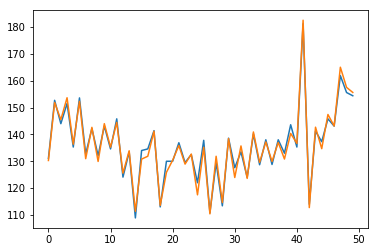

In [202]:
#ajout de bruit blanc au signal
dataNoisy=Variable(Tensor(train_input.size()))
for i in range(0,train_input.size(0)):
    for j in range(0,train_input.size(1)):
        noise = np.random.normal(0,2,50) #vector of 50 values with normal distribution of mean=0, std=2
        noiseVar=Variable(Tensor(noise))
        dataNoisy[i,j,:]=train_input[i,j,:].add(noiseVar)



#ajout de bruit blanc au signal
dataNoisy2=Variable(Tensor(train_input.size()))
for i in range(0,train_input.size(0)):
    for j in range(0,train_input.size(1)):
        noise = np.random.normal(0,4,50) #vector of 50 values with normal distribution of mean=0, std=2
        noiseVar=Variable(Tensor(noise))
        dataNoisy2[i,j,:]=train_input[i,j,:].add(noiseVar)




#verification
plt.plot(train_input[30,10,:].data.numpy())
plt.plot(dataNoisy[30,10,:].data.numpy())
train_input.size(1)

new_train_input = torch.cat((train_input, dataNoisy), 0) #the two matrices are concatenated
new_train_input = torch.cat((new_train_input, dataNoisy2), 0)

new_train_target=torch.cat((train_target, train_target), 0)
new_train_target=torch.cat((new_train_target, train_target), 0)
new_train_input.size()

0%
0%
0%
1%
1%
1%
2%
2%
2%
3%
3%
Epoch    10: reducing learning rate of group 0 to 5.0000e-04.
3%
4%
4%
4%
5%
5%
5%
6%
6%
6%
7%
Epoch    21: reducing learning rate of group 0 to 2.5000e-04.
7%
7%
8%
8%
8%
9%
9%
9%
10%
10%
10%
Epoch    32: reducing learning rate of group 0 to 1.2500e-04.
11%
11%
11%
12%
12%
12%
13%
13%
13%
14%
14%
Epoch    43: reducing learning rate of group 0 to 6.2500e-05.
14%
15%
15%
15%
16%
16%
16%
17%
17%
17%
18%
Epoch    54: reducing learning rate of group 0 to 3.1250e-05.
18%
18%
19%
19%
19%
20%
20%
20%
21%
21%
21%
Epoch    65: reducing learning rate of group 0 to 1.5625e-05.
22%
22%
22%
23%
23%
23%
24%
24%
24%
25%
25%
Epoch    76: reducing learning rate of group 0 to 7.8125e-06.
25%
26%
26%
26%
27%
27%
27%
28%
28%
28%
28%
Epoch    87: reducing learning rate of group 0 to 3.9063e-06.
29%
29%
30%
30%
30%
31%
31%
31%
32%
32%
32%
Epoch    98: reducing learning rate of group 0 to 1.9531e-06.
33%
33%
33%
34%
34%
34%
35%
35%
35%
36%
36%
Epoch   109: reducing learning r

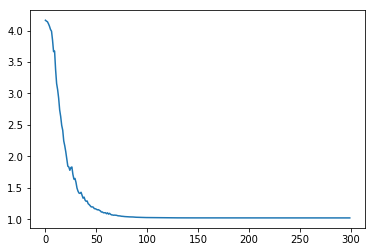

0%
0%
0%
1%
1%
1%
2%
2%
2%
3%
3%
Epoch    10: reducing learning rate of group 0 to 5.0000e-04.
3%
4%
4%
4%
5%
5%
5%
6%
6%
6%
7%
Epoch    21: reducing learning rate of group 0 to 2.5000e-04.
7%
7%
8%
8%
8%
9%
9%
9%
10%
10%
10%
Epoch    32: reducing learning rate of group 0 to 1.2500e-04.
11%
11%
11%
12%
12%
12%
13%
13%
13%
14%
14%
Epoch    43: reducing learning rate of group 0 to 6.2500e-05.
14%
15%
15%
15%
16%
16%
16%
17%
17%
17%
18%
Epoch    54: reducing learning rate of group 0 to 3.1250e-05.
18%
18%
19%
19%
19%
20%
20%
20%
21%
21%
21%
Epoch    65: reducing learning rate of group 0 to 1.5625e-05.
22%
22%
22%
23%
23%
23%
24%
24%
24%
25%
25%
Epoch    76: reducing learning rate of group 0 to 7.8125e-06.
25%
26%
26%
26%
27%
27%
27%
28%
28%
28%
28%
Epoch    87: reducing learning rate of group 0 to 3.9063e-06.
29%
29%
30%
30%
30%
31%
31%
31%
32%
32%
32%
Epoch    98: reducing learning rate of group 0 to 1.9531e-06.
33%
33%
33%
34%
34%
34%
35%
35%
35%
36%
36%
Epoch   109: reducing learning r

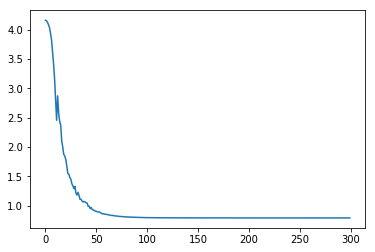

0%
0%
0%
1%
1%
1%
2%
2%
2%
3%
3%
Epoch    10: reducing learning rate of group 0 to 5.0000e-04.
3%
4%
4%
4%
5%
5%
5%
6%
6%
6%
7%
Epoch    21: reducing learning rate of group 0 to 2.5000e-04.
7%
7%
8%
8%
8%
9%
9%
9%
10%
10%
10%
Epoch    32: reducing learning rate of group 0 to 1.2500e-04.
11%
11%
11%
12%
12%
12%
13%
13%
13%
14%
14%
Epoch    43: reducing learning rate of group 0 to 6.2500e-05.
14%
15%
15%
15%
16%
16%
16%
17%
17%
17%
18%
Epoch    54: reducing learning rate of group 0 to 3.1250e-05.
18%
18%
19%
19%
19%
20%
20%
20%
21%
21%
21%
Epoch    65: reducing learning rate of group 0 to 1.5625e-05.
22%
22%
22%
23%
23%
23%
24%
24%
24%
25%
25%
Epoch    76: reducing learning rate of group 0 to 7.8125e-06.
25%
26%
26%
26%
27%
27%
27%
28%
28%
28%
28%
Epoch    87: reducing learning rate of group 0 to 3.9063e-06.
29%
29%
30%
30%
30%
31%
31%
31%
32%
32%
32%
Epoch    98: reducing learning rate of group 0 to 1.9531e-06.
33%
33%
33%
34%
34%
34%
35%
35%
35%
36%
36%
Epoch   109: reducing learning r

KeyboardInterrupt: 

In [192]:
# test multiple prior init
nb_epochs =  300
batch_size = 50


nb_training = 3

for i in range(0,nb_training):
    for p in model.parameters(): p.data.normal_(0, 0.01)
    loss_plot = []
    train_model(model, train_input, train_target, loss_plot, nb_epochs, batch_size = batch_size)
    
    
    
    print(' train_error {:.02f}% test_error {:.02f}%'.format(
                compute_nb_errors(model, train_input, train_target, 20) / train_input.size(0) * 100,
                compute_nb_errors(model, test_input, test_target, 50) / test_input.size(0) * 100))
    #loss_plot
    for p in model.parameters(): p.data.normal_(0, 0.01)
    plt.plot(range(nb_epochs),loss_plot)
    plt.show()
    
    

0%
0%
1%
2%
2%
3%
4%
4%
5%
6%
6%
7%
8%
8%
9%
10%
10%
11%
12%
12%
13%
14%
14%
15%
16%
16%
17%
18%
18%
19%
20%
Epoch    30: reducing learning rate of group 0 to 5.0000e-04.
20%
21%
22%
22%
23%
24%
24%
25%
26%
26%
27%
28%
28%
29%
30%
30%
31%
32%
32%
33%
34%
34%
35%
36%
36%
37%
38%
38%
39%
40%
40%
Epoch    61: reducing learning rate of group 0 to 2.5000e-04.
41%
42%
42%
43%
44%
44%
45%
46%
46%
47%
48%
48%
49%
50%
50%
51%
52%
52%
53%
54%
54%
55%
56%
56%
57%
57%
58%
59%
60%
60%
61%
Epoch    92: reducing learning rate of group 0 to 1.2500e-04.
62%
62%
63%
64%
64%
65%
66%
66%
67%
68%
68%
69%
70%
70%
71%
72%
72%
73%
74%
74%
75%
76%
76%
77%
78%
78%
79%
80%
80%
81%
82%
Epoch   123: reducing learning rate of group 0 to 6.2500e-05.
82%
83%
84%
84%
85%
86%
86%
87%
88%
88%
89%
90%
90%
91%
92%
92%
93%
94%
94%
95%
96%
96%
97%
98%
98%
99%
 train_error 0.00% test_error 30.00%


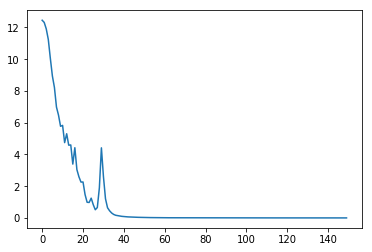

0%
0%
1%
2%
2%
3%
4%
4%
5%
6%
6%
7%
8%
8%
9%
10%
10%
11%
12%
12%
13%
14%
14%
15%
16%
16%
17%
18%
18%
19%
20%
Epoch    30: reducing learning rate of group 0 to 5.0000e-04.
20%
21%
22%
22%
23%
24%
24%
25%
26%
26%
27%
28%
28%
29%
30%
30%
31%
32%
32%
33%
34%
34%
35%
36%
36%
37%
38%
38%
39%
40%
40%
Epoch    61: reducing learning rate of group 0 to 2.5000e-04.
41%
42%
42%
43%
44%
44%
45%
46%
46%
47%
48%
48%
49%
50%
50%
51%
52%
52%
53%
54%
54%
55%
56%
56%
57%
57%
58%
59%
60%
60%
61%
Epoch    92: reducing learning rate of group 0 to 1.2500e-04.
62%
62%
63%
64%
64%
65%
66%
66%
67%
68%
68%
69%
70%
70%
71%
72%
72%
73%
74%
74%
75%
76%
76%
77%
78%
78%
79%
80%
80%
81%
82%
Epoch   123: reducing learning rate of group 0 to 6.2500e-05.
82%
83%
84%
84%
85%
86%
86%
87%
88%
88%
89%
90%
90%
91%
92%
92%
93%
94%
94%
95%
96%
96%
97%
98%
98%
99%
 train_error 0.00% test_error 27.00%


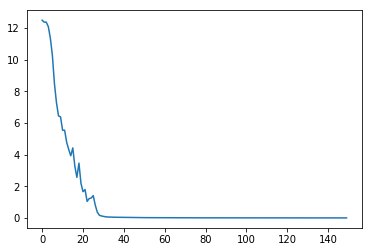

0%
0%
1%
2%
2%
3%
4%
4%
5%
6%
6%
7%
8%
8%
9%
10%
10%
11%
12%
12%
13%
14%
14%
15%
16%
16%
17%
18%
18%
19%
20%
Epoch    30: reducing learning rate of group 0 to 5.0000e-04.
20%
21%
22%
22%
23%
24%
24%
25%
26%
26%
27%
28%
28%
29%
30%
30%
31%
32%
32%
33%
34%
34%
35%
36%
36%
37%
38%
38%
39%
40%
40%
Epoch    61: reducing learning rate of group 0 to 2.5000e-04.
41%
42%
42%
43%
44%
44%
45%
46%
46%
47%
48%
48%
49%
50%
50%
51%
52%
52%
53%
54%
54%
55%
56%
56%
57%
57%
58%
59%
60%
60%
61%
Epoch    92: reducing learning rate of group 0 to 1.2500e-04.
62%
62%
63%
64%
64%
65%
66%
66%
67%
68%
68%
69%
70%
70%
71%
72%
72%
73%
74%
74%
75%
76%
76%
77%
78%
78%
79%
80%
80%
81%
82%
Epoch   123: reducing learning rate of group 0 to 6.2500e-05.
82%
83%
84%
84%
85%
86%
86%
87%
88%
88%
89%
90%
90%
91%
92%
92%
93%
94%
94%
95%
96%
96%
97%
98%
98%
99%
 train_error 0.00% test_error 23.00%


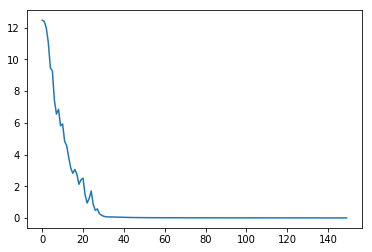

In [203]:
# test multiple prior init
nb_epochs =  150
batch_size = 50


nb_training = 3

for i in range(0,nb_training):
    for p in model.parameters(): p.data.normal_(0, 0.01)
    loss_plot = []
    train_model(model, new_train_input, new_train_target, loss_plot, nb_epochs, batch_size = batch_size)
    
    
    
    print(' train_error {:.02f}% test_error {:.02f}%'.format(
                compute_nb_errors(model, new_train_input, new_train_target, 20) / new_train_input.size(0) * 100,
                compute_nb_errors(model, test_input, test_target, 50) / test_input.size(0) * 100))
    #loss_plot
    for p in model.parameters(): p.data.normal_(0, 0.01)
    plt.plot(range(nb_epochs),loss_plot)
    plt.show()

In [29]:
train_input.size()

torch.Size([300, 28, 50])

In [30]:
A


(0 ,.,.) = 
  7.1955e-12
  4.5786e-41
  1.1726e+29

(1 ,.,.) = 
  3.0799e-41
  0.0000e+00
  9.8091e-45

(2 ,.,.) = 
  1.0000e+00
  1.0000e+00
  1.0000e+00

(3 ,.,.) = 
  0.0000e+00
  0.0000e+00
  0.0000e+00
[torch.FloatTensor of size 4x3x1]

In [31]:
A.unsqueeze(1)


(0 ,0 ,.,.) = 
  7.1955e-12
  4.5786e-41
  1.1726e+29

(1 ,0 ,.,.) = 
  3.0799e-41
  0.0000e+00
  9.8091e-45

(2 ,0 ,.,.) = 
  1.0000e+00
  1.0000e+00
  1.0000e+00

(3 ,0 ,.,.) = 
  0.0000e+00
  0.0000e+00
  0.0000e+00
[torch.FloatTensor of size 4x1x3x1]

NameError: name 'self' is not defined

In [50]:
a=[1 ,2, 3, 4]

In [57]:
a=Variable(Tensor(a))

In [70]:
a
print(a)
print(a)

Variable containing:
 1
 2
 3
 4
[torch.FloatTensor of size 4x1]

Variable containing:
 1
 2
 3
 4
[torch.FloatTensor of size 4x1]



In [62]:
a=a.unsqueeze(1)

In [42]:
 def valSet(train_input,percentageVal):
    permutation = torch.randperm(train_input.size()[0])
    sizeVal=round(percentageVal/100*train_input.size()[0])
    
    validation_set=train_input[permutation].narrow(0,0,sizeVal)
    new_train_input=train_input[permutation].narrow(0,sizeVal,train_input.size()[0]-sizeVal)
    return new_train_input, validation_set
valSet

In [43]:
a,b = valSet(train_input,20)
print(a.size())
print(b.size())

torch.Size([240, 28, 50])
torch.Size([60, 28, 50])


In [22]:
A=Variable(Tensor(3,3))
A

Variable containing:
-3.2324e+19  4.5723e-41  2.7140e+19
 3.0915e-41  4.1723e-08  2.9094e+00
 2.6578e+28  3.1287e+00  6.7262e-44
[torch.FloatTensor of size 3x3]

In [35]:
permutation = torch.randperm(3)
B=A[permutation].narrow(0,0,2)
B

Variable containing:
-3.2324e+19  4.5723e-41  2.7140e+19
 3.0915e-41  4.1723e-08  2.9094e+00
[torch.FloatTensor of size 2x3]

In [26]:
train_input.size()

torch.Size([300, 28, 50])